In [373]:
import os
import cv2
import numpy as np
from collections import defaultdict

import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional, ConvLSTM2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

happy has 207 number of images
fear has 75 number of images
surprise has 249 number of images
sadness has 84 number of images
anger has 135 number of images


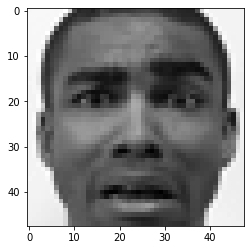

In [3]:
INPUT_PATH = "./CK+48/"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    if dir_==".DS_Store":
        continue
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")


inp_pa = "./CK+48/fear/"
from skimage.io import imread
for dir in os.listdir(inp_pa):
  im = imread(inp_pa+dir)
  pyplot.imshow(im,cmap='gray')
  # print(type(im))

TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

In [4]:
INPUT_PATH = "./CK+48/"
data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

# data

In [5]:
from scipy.fftpack import dct

In [6]:
### Processing images into array form
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f,0)
        imgF = dct2(img)
        imgF = imgF[0:48,0:48]
        imgF = imgF*3
        arr[i] = imgF
    return arr

In [11]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

# data

In [12]:
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

happy has 69 samples
fear has 25 samples
surprise has 83 samples
sadness has 28 samples
anger has 45 samples


### Making a data of all images of emotions in separate array

In [13]:
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = np_utils.to_categorical(y)

X.shape, y.shape

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


((250, 3, 48, 48, 1), (250, 5))

### Combining all 5 array 3 times

In [14]:
X1 = np.concatenate((surprise, happy, anger, sadness, fear,surprise, happy, anger, sadness, fear,surprise, happy, anger, sadness, fear))
y1 = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25),np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25),np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y1 = np_utils.to_categorical(y1)

print(X1.shape)
print(y1.shape)


(750, 3, 48, 48, 1)
(750, 5)


In [33]:
x = np.squeeze(X1)

In [36]:
print(x.shape)

i1=x[0][0]
i2=x[0][1]

print(i1.shape)
print(i2.shape)

(750, 3, 48, 48)
(48, 48)
(48, 48)


In [57]:
from scipy.fftpack import dct, idct
# implement 2D IDCT
def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

In [40]:
im1 = idct2(i1)
im2 = idct2(i2)

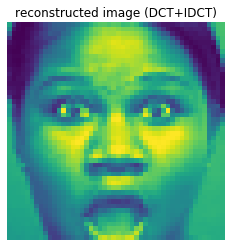

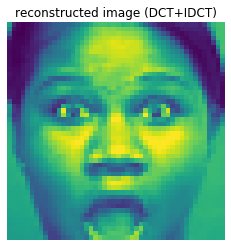

In [42]:
from skimage.io import imread
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pylab as plt

plt.imshow(im1), plt.axis('off'), plt.title('reconstructed image (DCT+IDCT)')
plt.show()

plt.imshow(im2), plt.axis('off'), plt.title('reconstructed image (DCT+IDCT)')
plt.show()

In [15]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

In [16]:
# X_train, X_valid, y_train, y_valid = train_test_split(X1, y1, train_size=0.8, stratify=y1, shuffle=True, random_state=42)
# X_train.shape, X_valid.shape
X_train = X1
y_train = y1


In [17]:
# y_train.shape,y_valid.shape

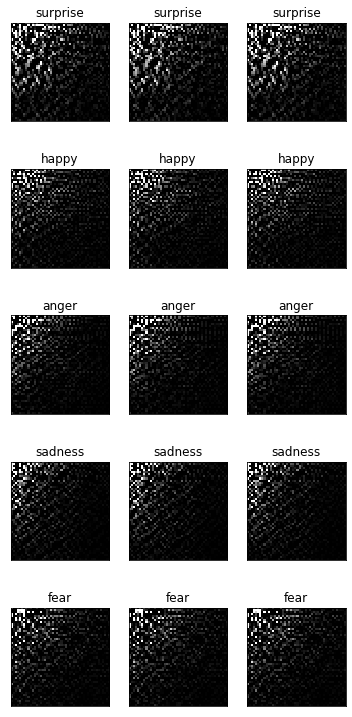

In [18]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        arr = np.asarray(sample_img)
        ax.imshow(arr, cmap='gray', vmin=0, vmax=255)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [19]:
# data normalization
X_train = X_train / 255.
# X_valid = X_valid / 255.

X_train.shape #, X_valid.shape

(750, 3, 48, 48, 1)

In [31]:
import tensorflow as tf 
classifierLoad = tf.keras.models.load_model('./Emotion_CNN.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
predi = classifierLoad.predict(X_train)

In [22]:
predi.shape

(750, 3, 5)

In [23]:
predi[110]

array([[4.8781277e-07, 9.9998438e-01, 1.2608976e-05, 1.9590702e-07,
        2.3055163e-06],
       [4.3492285e-08, 9.9999940e-01, 4.4432414e-07, 2.0396090e-08,
        1.7582623e-07],
       [3.2417159e-08, 9.9999940e-01, 3.9390287e-07, 2.9791945e-08,
        2.2264301e-07]], dtype=float32)

In [24]:
predictions = []
for i in range(0,749):
    result = predi[i].sum(axis=0)
    j = np.unravel_index(result.argmax(),result.shape)
#     print(j[0])
    predictions.append(j[0])


In [25]:
print(predictions)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Testing sample data apart from test data

In [374]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.preprocessing import image

In [392]:
path = './test_data/'
TOP_EMOTIONS = ["surprise", "happy", "anger", "sadness", "fear"]

In [399]:
def find_expression(img):
    arr = np.empty(shape=(3,48,48,1))
    img = cv2.resize(img,(48,48))
    imf = dct2(img)
    imf = imf*3
    imf = image.img_to_array(imf)
    arr[0] = imf
    arr[1] = imf
    arr[2] = imf
    arr=arr/255.0
    arr = np.expand_dims(arr, axis=0)
    predi = classifierLoad.predict(arr)
    result = predi[0].sum(axis=0)
#     print(result)
    j = np.unravel_index(result.argmax(),result.shape)

    print(TOP_EMOTIONS[j[0]])

anger


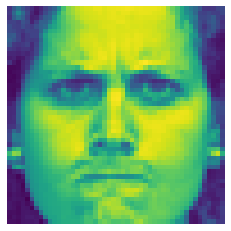

surprise


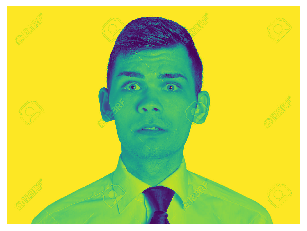

surprise


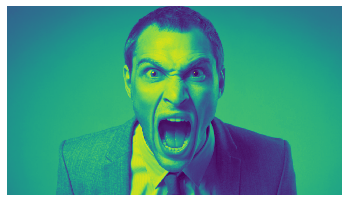

anger


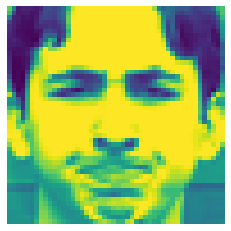

In [406]:
for dir in os.listdir(path):
    if dir=='.DS_Store':
        continue

    # Read Images
    img = cv2.imread(path+dir,0)
    plt.imshow(img)
    find_expression(img)
    plt.axis("off")
    plt.show()